In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec



In [ ]:
#load the glove word2vec 100 dimension model which is saved on our drive as word2vec.gz
model=gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/Datathon/word2vec.gz")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#load the data
import pandas as pd
d1_path="/content/drive/My Drive/Datathon/combined.csv"
data_frame=pd.read_csv(d1_path)

In [ ]:
#drop the data points with the same sku_id
data_frame=data_frame.drop_duplicates(subset="sku_id",keep="first")
data_frame.head()

,sku_id,title,category,specifications,price,rating,no_of_reviews,outlink_sku_ids,outlinks,url
0,206750547,"Lenovo 81JW0001US Chromebook S330, 14"" HD Disp...",Electronics,"{'Processor Brand': 'MediaTek', 'Processor Typ...",$239.00,4.1,476,"['965386169', '726338035', '620162156', '55315...",['https://www.walmart.com/ip/Acer-Chromebook-1...,https://www.walmart.com/ip/Lenovo-81JW0001US-C...
1,620162156,"EVOO 11.6"" Chromebook, Quad Core, 16GB Storage...",Electronics,"{'Processor Brand': 'Rockchip', 'Processor Typ...",$119.00,3.9,63,"['227737612', '44363066', '658934269', '767004...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/EVOO-11-6-Chromeboo...
2,658934269,(Refurbished) Dell Chromebook 11 (CB1C13) 11.6...,Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$144.95,3.8,26,"['227737612', '564694293', '44363066', '620162...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/Refurbished-Dell-Ch...
3,44363066,"Dell Chromebook - 11.6"" - Celeron N2840 - 4 GB...",Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$138.22,3.4,183,"['620162156', '227737612', '564694293', '72633...",['https://www.walmart.com/ip/EVOO-11-6-Chromeb...,https://www.walmart.com/ip/Dell-Chromebook-11-...
4,387968358,"RCA Galileo Pro 11.5"" 32GB 2-in-1 Tablet with ...",Electronics,"{'Brand': 'RCA', 'Manufacturer Part Number': '...",$97.99,4.0,4131,"['122743261', '53990885', '943912312', '556390...",['https://www.walmart.com/ip/3-Pack-Supershiel...,https://www.walmart.com/ip/RCA-Galileo-Pro-11-...


In [ ]:
#method to clean the data
def clean_df(data_frame):
  col=[]
  for index, row in data_frame.iterrows():
    lower_c=row["title"]+" "+row["specifications"]+" "+row["category"]
    lower_c=lower_c.replace("'","")
    lower_c=lower_c.lower()
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    lower_c = tokenizer.tokenize(lower_c)
    lower_c=list(set(lower_c))
    col.append(lower_c)
  
  data_frame["combined_data"]=col
  return data_frame

In [ ]:
#cleaning the data
import string
import nltk
data_frame=clean_df(data_frame)
data_frame.head()

,sku_id,title,category,specifications,price,rating,no_of_reviews,outlink_sku_ids,outlinks,url,combined_data
0,206750547,"Lenovo 81JW0001US Chromebook S330, 14"" HD Disp...",Electronics,"{'Processor Brand': 'MediaTek', 'Processor Typ...",$239.00,4.1,476,"['965386169', '726338035', '620162156', '55315...",['https://www.walmart.com/ip/Acer-Chromebook-1...,https://www.walmart.com/ip/Lenovo-81JW0001US-C...,"[processor, 0, inches, ram, maximum, 81jw0001u..."
1,620162156,"EVOO 11.6"" Chromebook, Quad Core, 16GB Storage...",Electronics,"{'Processor Brand': 'Rockchip', 'Processor Typ...",$119.00,3.9,63,"['227737612', '44363066', '658934269', '767004...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/EVOO-11-6-Chromeboo...,"[processor, 0, 11, inches, ram, bk, system, 50..."
2,658934269,(Refurbished) Dell Chromebook 11 (CB1C13) 11.6...,Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$144.95,3.8,26,"['227737612', '564694293', '44363066', '620162...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/Refurbished-Dell-Ch...,"[cb1c13, processor, 11, ram, system, part, cel..."
3,44363066,"Dell Chromebook - 11.6"" - Celeron N2840 - 4 GB...",Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$138.22,3.4,183,"['620162156', '227737612', '564694293', '72633...",['https://www.walmart.com/ip/EVOO-11-6-Chromeb...,https://www.walmart.com/ip/Dell-Chromebook-11-...,"[dual, processor, adapter, 11, inches, ram, en..."
4,387968358,"RCA Galileo Pro 11.5"" 32GB 2-in-1 Tablet with ...",Electronics,"{'Brand': 'RCA', 'Manufacturer Part Number': '...",$97.99,4.0,4131,"['122743261', '53990885', '943912312', '556390...",['https://www.walmart.com/ip/3-Pack-Supershiel...,https://www.walmart.com/ip/RCA-Galileo-Pro-11-...,"[android, charcoal, marshmallow, 0, 11, system..."


In [ ]:
import numpy as np

In [ ]:
#method to obtain word embeddings
def obtain_word_vectors(data_frame,model1):
  vectors1=[]
  for index,row in data_frame.iterrows():
    data=row["combined_data"]
    l=0
    v=np.zeros(100)
    for i in data:
      if(i in model.vocab):
        temp=model.get_vector(i)
        v=v+temp
        l=l+1
    v=v/l
    vectors1.append(v)
  data_frame["vectors"]=vectors1
  return data_frame

In [ ]:
data_frame=obtain_word_vectors(data_frame,model)
data_frame.head()

,sku_id,title,category,specifications,price,rating,no_of_reviews,outlink_sku_ids,outlinks,url,combined_data,vectors
0,206750547,"Lenovo 81JW0001US Chromebook S330, 14"" HD Disp...",Electronics,"{'Processor Brand': 'MediaTek', 'Processor Typ...",$239.00,4.1,476,"['965386169', '726338035', '620162156', '55315...",['https://www.walmart.com/ip/Acer-Chromebook-1...,https://www.walmart.com/ip/Lenovo-81JW0001US-C...,"[processor, 0, inches, ram, maximum, 81jw0001u...","[-0.24545783465345428, 0.34555510775989867, 0...."
1,620162156,"EVOO 11.6"" Chromebook, Quad Core, 16GB Storage...",Electronics,"{'Processor Brand': 'Rockchip', 'Processor Typ...",$119.00,3.9,63,"['227737612', '44363066', '658934269', '767004...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/EVOO-11-6-Chromeboo...,"[processor, 0, 11, inches, ram, bk, system, 50...","[-0.2936774724305181, 0.3544210659624156, 0.18..."
2,658934269,(Refurbished) Dell Chromebook 11 (CB1C13) 11.6...,Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$144.95,3.8,26,"['227737612', '564694293', '44363066', '620162...",['https://www.walmart.com/ip/Refurbished-DELL-...,https://www.walmart.com/ip/Refurbished-Dell-Ch...,"[cb1c13, processor, 11, ram, system, part, cel...","[-0.24954652341760017, 0.26320829534564505, 0...."
3,44363066,"Dell Chromebook - 11.6"" - Celeron N2840 - 4 GB...",Electronics,"{'Processor Brand': 'Intel', 'Processor Type':...",$138.22,3.4,183,"['620162156', '227737612', '564694293', '72633...",['https://www.walmart.com/ip/EVOO-11-6-Chromeb...,https://www.walmart.com/ip/Dell-Chromebook-11-...,"[dual, processor, adapter, 11, inches, ram, en...","[-0.2310956045985222, 0.3532866202012608, 0.13..."
4,387968358,"RCA Galileo Pro 11.5"" 32GB 2-in-1 Tablet with ...",Electronics,"{'Brand': 'RCA', 'Manufacturer Part Number': '...",$97.99,4.0,4131,"['122743261', '53990885', '943912312', '556390...",['https://www.walmart.com/ip/3-Pack-Supershiel...,https://www.walmart.com/ip/RCA-Galileo-Pro-11-...,"[android, charcoal, marshmallow, 0, 11, system...","[-0.12689303189259152, 0.2987967937028614, 0.1..."


In [ ]:
print(len(data_frame))

7359


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift

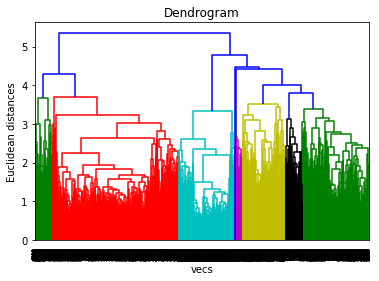

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
dendrogram = sch.dendrogram(sch.linkage(list(data_frame["vectors"].values), method  = "complete"))
plt.title('Dendrogram')
plt.xlabel('vecs')
plt.ylabel('Euclidean distances')
plt.show()


In [ ]:
#methods to carryout clustering
def aglomerative_Clustering(data_frame1,metric,ward,n_clusters,distance):
  cluster=AgglomerativeClustering(affinity=metric,linkage=ward,distance_threshold=distance,n_clusters=n_clusters)
  labels=cluster.fit_predict(list(data_frame1["vectors"]))
  return labels

def meanshift_Clustering(data_frame1):
  cluster=MeanShift(bandwidth=0.6)
  labels=cluster.fit_predict(list(data_frame1["vectors"]))
  return labels

In [ ]:
#carrying out aglomerative hierarchical clustering
labels=aglomerative_Clustering(data_frame,"manhattan","complete",None,20)

In [ ]:
#adding the labels columns to the data
data_frame["labels"]=labels

In [ ]:
#save the data frame with labels as a pickle file
data_frame.to_pickle("/content/drive/My Drive/Datathon/combined_pickle.pickle")

In [ ]:
#load the data frame with labels as a pickle file
data_frame1=pd.read_pickle("/content/drive/My Drive/Datathon/combined_pickle.pickle")

In [ ]:
from numpy import dot
from numpy.linalg import norm
#combined method to obatin top predictions on a query string
def clustering_method(query_str,processed_dataframe_path,model):

#method to calculate the cosine similarity
  def cos_similarity(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

#obtain average word embeddings per cluster
  def obtain_class_dict(data_frame1):
    class_dict={}
    for i in range(len(set(data_frame1["labels"]))):
      embeds=data_frame1[data_frame1["labels"]==i]["vectors"].values
      class_dict[i]=np.mean(embeds,axis=0)

    return class_dict

#method to clean the query string
  def clean_query(query_str):
    q=query_str.lower()
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    q= tokenizer.tokenize(q)
    q=list(set(q))
    return q

#method to obtain query word embeddings
  def obtain_query_embeddings(q,model):
    v=np.zeros(100)
    l=0
    for i in q:
      if(i in model.vocab):
        temp=model.get_vector(i)
        v=v+temp
        l=l+1
    v=v/l
    return v

#method to obtain the similarities of the query within the cluster to which it belongs to and sort by the sosine similarity
  def sort_by_similarity(c_dict,v,data_frame1):
    similarities=[cos_similarity(x,v) for x in c_dict.values()]
    pred=np.argmax(similarities)
    d_pred=data_frame1[data_frame1['labels']==pred]
    d_sim=[]
    #iterate over the dataframe of the predicted label
    for index,row in d_pred.iterrows():
      d_sim.append(cos_similarity(row["vectors"],v))
    d_pred["similarity"]=d_sim
    d_pred=d_pred.sort_values(by="similarity",ascending=False)
    return d_pred


  def query_label(c_dict,query_str,data_frame1,model):
    q=clean_query(query_str)
    v=obtain_query_embeddings(q,model)
    d_pred=sort_by_similarity(c_dict,v,data_frame1)
    return d_pred

    
  data_frame1=pd.read_pickle(processed_dataframe_path) #load dataframe
  c_dict=obtain_class_dict(data_frame1)#obatin the average word embeddings
  preds=query_label(c_dict,query_str,data_frame,model)#final sorted predictions according to the query


  return preds

In [25]:
#testing on a query string
p1=clustering_method("loreal paris","/content/drive/My Drive/Datathon/combined_pickle.pickle",model)
p1.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sku_id,title,category,specifications,price,rating,no_of_reviews,outlink_sku_ids,outlinks,url,combined_data,vectors,labels,similarity
1733,48206609,"L'Oreal Paris Colour Riche Monos Eyeshadow, Ma...",Beauty/Makeup/Going Out Makeup,{},$4.97,4.4,225,"['362252930', '253789770', '55175820', '117788...",['https://www.walmart.com/ip/L-Oreal-Paris-Mak...,https://www.walmart.com/ip/L-Oreal-Paris-Colou...,"[riche, mademoiselle, oz, loreal, 0, beauty, g...","[0.06453540126482646, 0.1704473299284776, 0.08...",5,0.474816
1623,51222493,"L'Oreal Paris Voluminous Primer Mascara, White...",Beauty/Travel Size Beauty/Travel Size Makeup/T...,{},$6.74,4.5,1809,"['291049593', '17236834', '148044403', '274127...",['https://www.walmart.com/ip/Masqueology-Gold-...,https://www.walmart.com/ip/L-Oreal-Paris-Volum...,"[size, eye, oz, loreal, primer, fl, 0, white, ...","[-0.11550072757527233, 0.11455197536076109, 0....",5,0.457026
1839,205230927,L'Oreal Paris Elvive Dream Lengths No Haircut ...,Beauty/Spring Break Beauty/Haircare,{},$5.97,4.6,214,"['376265312', '245555672', '687560698', '14602...",['https://www.walmart.com/ip/L-Oreal-Paris-Elv...,https://www.walmart.com/ip/L-Oreal-Paris-Elviv...,"[haircut, no, 6, elvive, 8, oz, loreal, hairca...","[0.08153916833301385, 0.12317314027394685, 0.0...",5,0.451249
1840,117788455,"L'Oreal Paris Colour Riche Monos Eyeshadow, Ma...",Beauty/Beauty by Top Brands/L'Oreal/L'Oreal Ma...,{},$4.97,4.4,225,"['362252930', '253789770', '50941567', '165934...",['https://www.walmart.com/ip/L-Oreal-Paris-Mak...,https://www.walmart.com/ip/L-Oreal-Paris-Colou...,"[riche, matte, oz, brands, loreal, chill, 0, b...","[-0.02512456418480724, 0.13235205854289234, 0....",5,0.444248
4279,803425535,L'Oreal Paris True Match Lumi Shimmerista High...,Beauty/Makeup/Face Makeup/Highlighter Makeup/H...,{},$8.89,4.6,155,"['152767993', '129899762', '850818927', '16929...",['https://www.walmart.com/ip/L-Oreal-Paris-Tru...,https://www.walmart.com/ip/L-Oreal-Paris-True-...,"[moonlight, face, true, oz, loreal, highlighti...","[0.013143140325943629, 0.18376199901103973, 0....",5,0.429334
4910,10314825,L'Oreal Paris Telescopic Original Washable Int...,Beauty/Travel Size Beauty/Travel Size Makeup/T...,{},$8.44,4.1,936,"['876988918', '10314521', '892281428', '103143...",['https://www.walmart.com/ip/L-Oreal-Paris-Air...,https://www.walmart.com/ip/L-Oreal-Paris-Teles...,"[lengthening, washable, size, oz, eye, loreal,...","[-0.14158594196972749, 0.16165768287868965, 0....",5,0.428302
4004,974282675,L'Oreal Paris True Match Lumi Glotion Natural ...,Beauty/Makeup/Face Makeup/Highlighter Makeup/L...,{},$11.44,4.5,497,"['394982475', '158036401', '152767993', '36225...",['https://www.walmart.com/ip/L-Oreal-Paris-Tru...,https://www.walmart.com/ip/L-Oreal-Paris-True-...,"[face, true, oz, loreal, glow, highlighter, fl...","[0.1153101818088223, 0.2256141721325762, 0.252...",5,0.423893
4208,546286195,L'Oreal Paris True Match Lumi Glow Nude highli...,Beauty/Makeup/Face Makeup/Face Primer,{},$11.44,4.0,190,[],[],https://www.walmart.com/ip/L-Oreal-Paris-True-...,"[face, true, nude, loreal, glow, highlighter, ...","[0.050577940652146935, 0.19628924899734557, 0....",5,0.421909
4471,303343432,"L'Oreal Paris Lash Paradise Mascara, Voluminou...",Beauty/Makeup/Eye Makeup/Mascara/L'Oreal Mascara,{},$9.97,4.2,1978,"['133805243', '236339328', '618241721', '10312...",['https://www.walmart.com/ip/L-Oreal-Paris-Vol...,https://www.walmart.com/ip/L-Oreal-Paris-Lash-...,"[paradise, blackest, oz, eye, loreal, fl, lash...","[-0.04546953045452635, 0.09716686283548673, 0....",5,0.411460
4763,44910770,"L'Oreal Paris Age Perfect Eye Renewal, 0.5 fl....",Beauty/Here for Every Beauty/Skincare/Eye Crea...,{},$15.32,4.2,1137,"['159500009', '38102600', '888169', '38102599'...",['https://www.walmart.com/ip/L-Oreal-Paris-Age...,https://www.walmart.com/ip/L-Oreal-Paris-Age-P...,"[every, renewal, eye, oz, perfect, loreal, 5, ...","[0.015748295275604025, 0.3286912890479845, 0.1...",5,0.407199
